In [15]:
import pandas as pd
import numpy as np
# from dataprep.eda import create_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


In [25]:
df_train = pd.read_csv('train_users_2.csv')
# df_test = pd.read_csv('test_users.csv')
# df_country = pd.read_csv('countries.csv')
df_age = pd.read_csv('age_gender_bkts.csv')
df_sessions = pd.read_csv('sessions.csv')

In [ ]:
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB


## Age bucket distribution
https://www.kaggle.com/code/asmaamohy/airbnb-eda had a good few charts, this is one of the best ones I found

<ipython-input-6-44f42654d071>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_age,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)


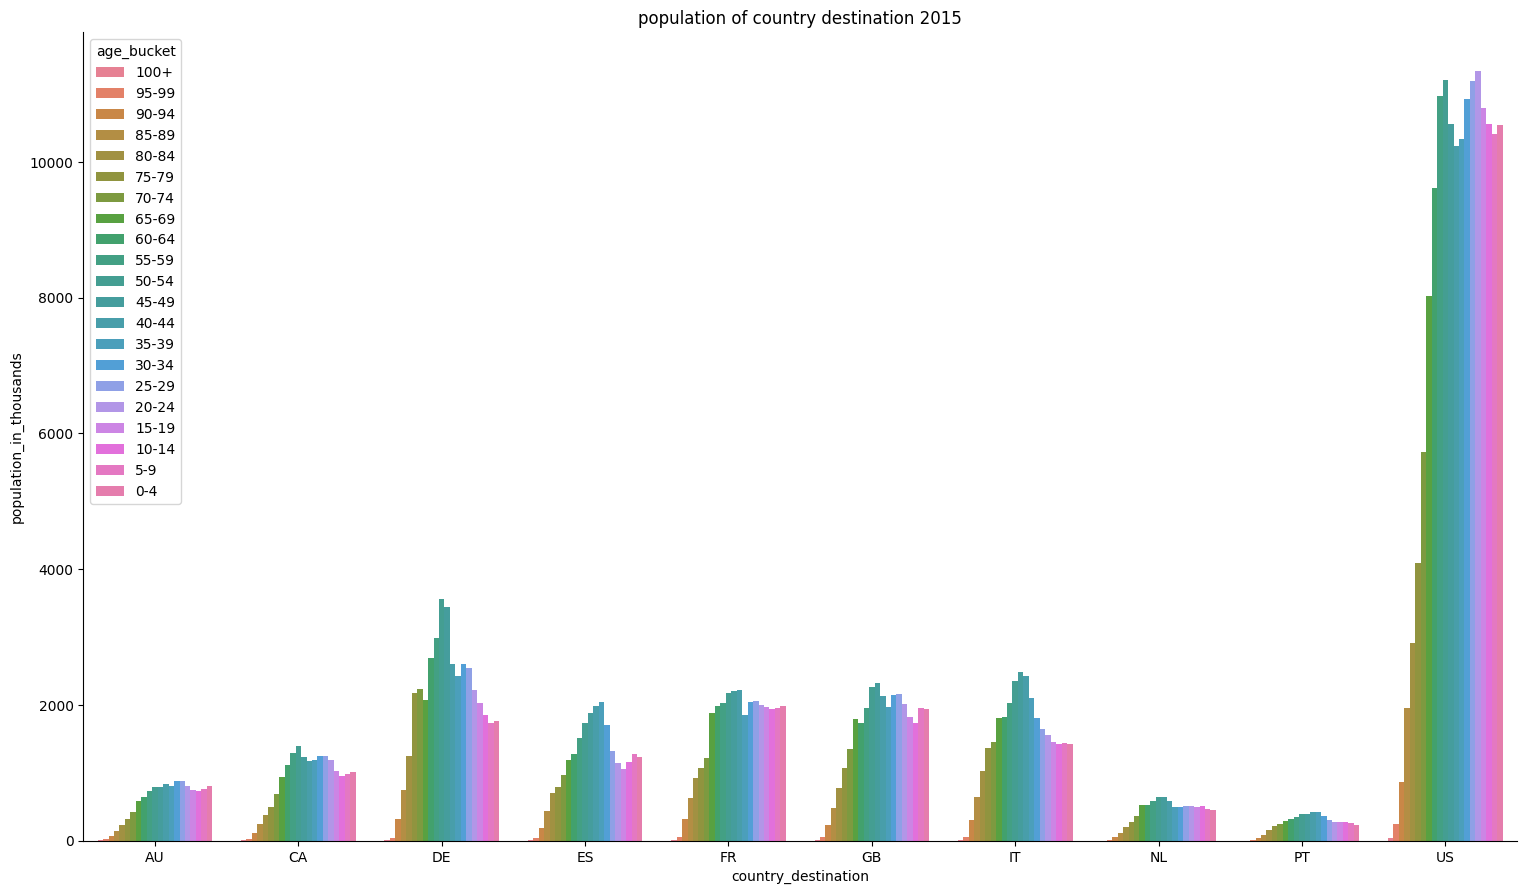

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.barplot(data=df_age,x="country_destination",y="population_in_thousands",hue='age_bucket',ci=None,ax=ax)
plt.title('population of country destination 2015')
sns.despine()

## I liked this from Pawans Analysis

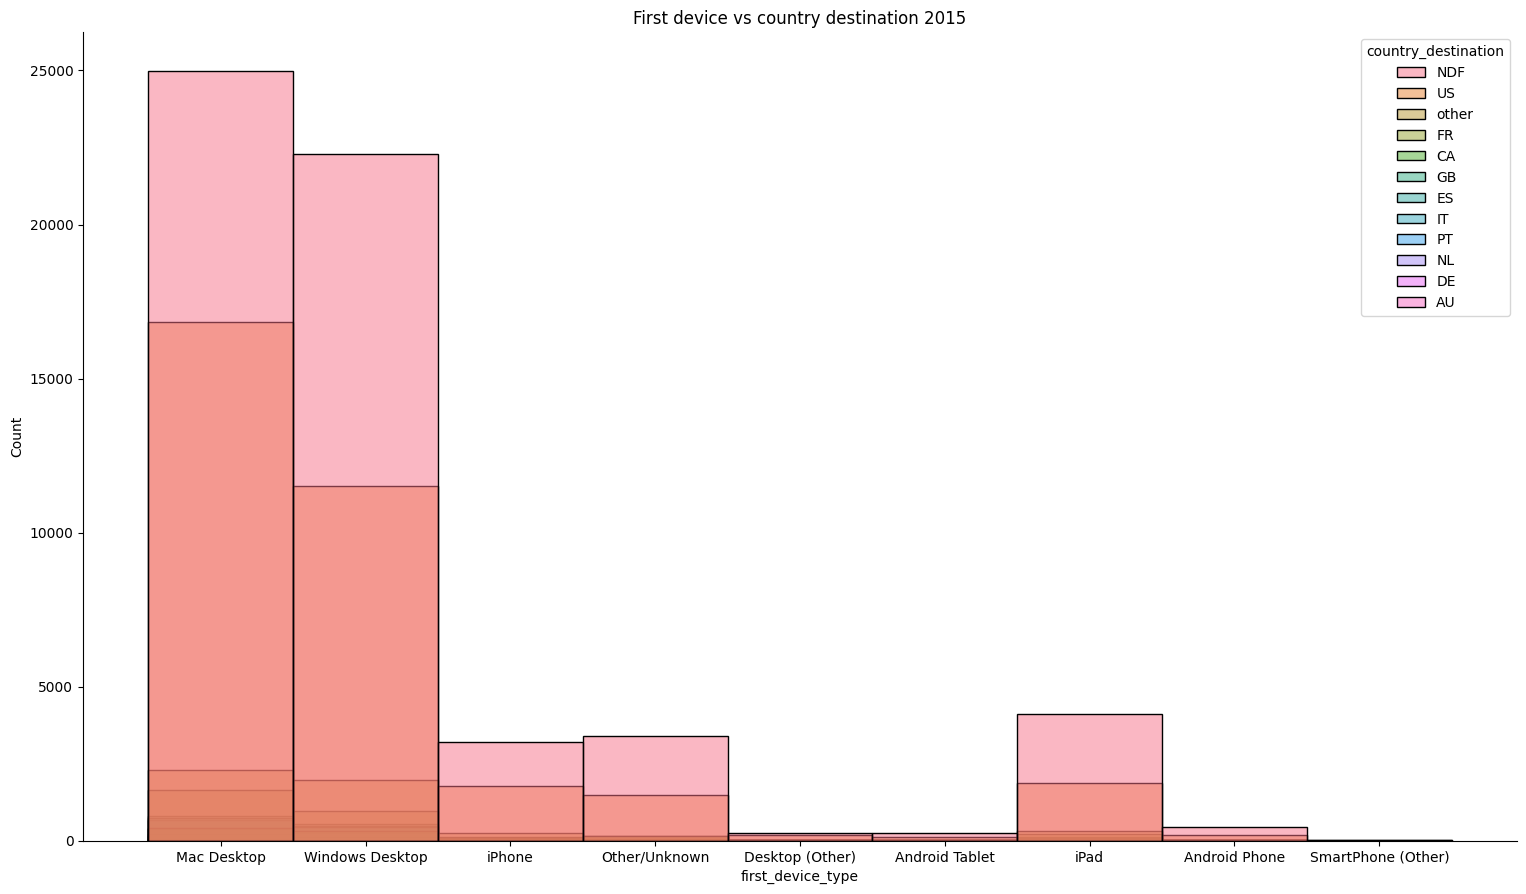

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
sns.histplot(data=df_train,x="first_device_type",hue='country_destination',ax=ax)
plt.title('First device vs country destination 2015')
sns.despine()

In [ ]:
missing_value_counts = df_train.isnull().sum()
print(missing_value_counts)
print(df_train.shape[0])

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking             0
gender                         0
age                        40418
signup_method                  0
signup_flow                    1
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked        0
signup_app                     0
first_device_type              0
first_browser                  0
country_destination            0
dtype: int64
107749


In [8]:
# Splitting features and target
X = df_train.drop('country_destination', axis=1)
y = df_train['country_destination']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE sampling to distribute more evenly across language
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
X_resampled_test, y_resampled_test = smote.fit_resample(X_test, y_test)

# Checking the class distribution
print(f'Original dataset class distribution:\n{y_train.value_counts()}')
print(f'Resampled dataset class distribution:\n{pd.Series(y_resampled).value_counts()}')

combined_data = pd.concat([X_resampled, y_resampled], axis=1)
combined_test = pd.concat([X_resampled_test, y_resampled_test], axis=1)
print(combined_data.head())

## Data After Sampling Histograms


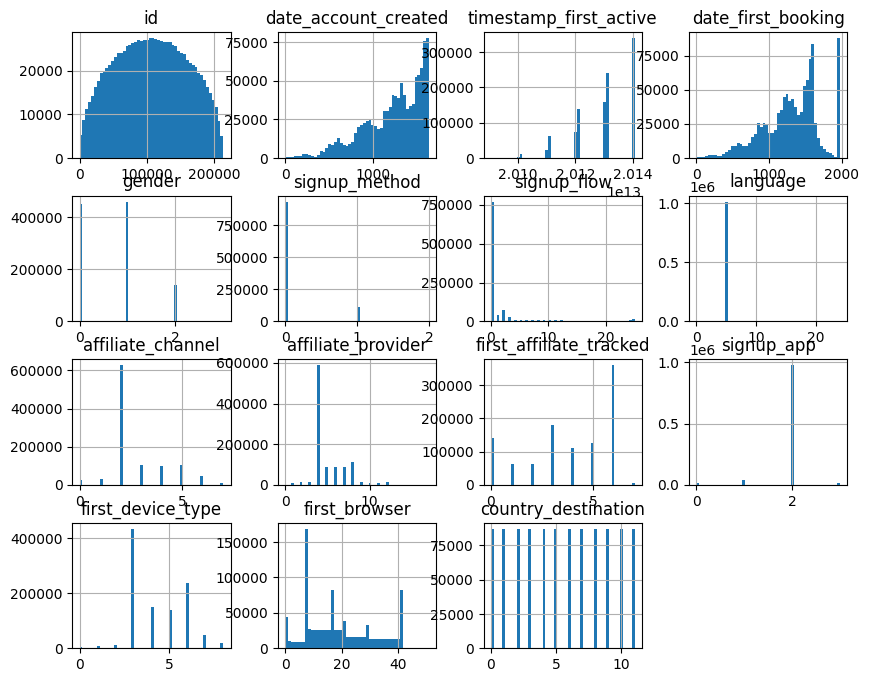

In [ ]:
combined_data.hist(figsize=(10,8), bins=50)
plt.show()

## Data without Sampling Histograms

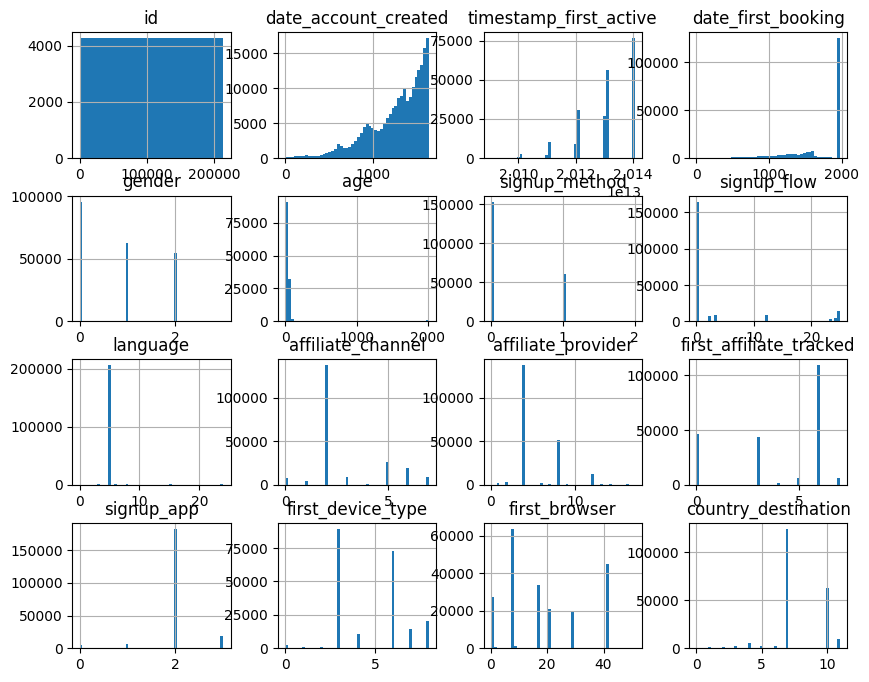

In [ ]:
df_train.hist(figsize=(10,8), bins=50)
plt.show()

## Data After Sampling Heatmap

In [ ]:
correlation_matrix = combined_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

## Data Before Sampling Heatmap

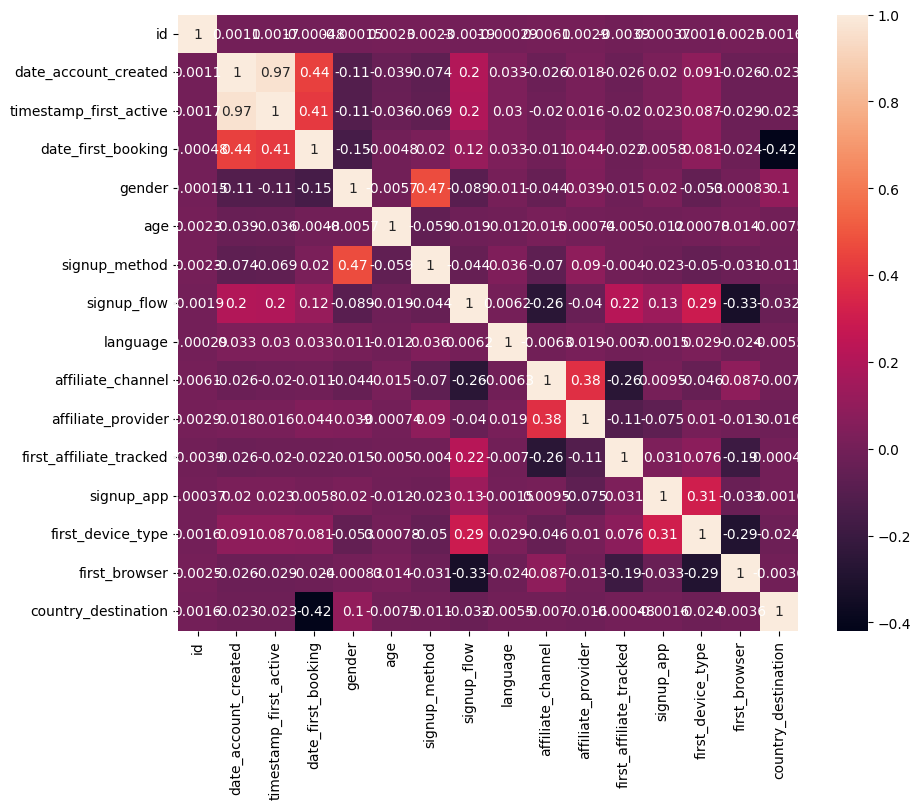

In [ ]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

In [26]:
# Potentially users that are missing gender, country destination and age are not
# users we shoudl be using to train as they are missing a lot of information,
# This section is designed to find those, see if the user id exists in the sessions
flagged_rows = df_train.loc[(df_train['gender'] == '-unknown-') \
                            & (df_train['country_destination'] == 'NDF') \
                            & (df_train['age'].isna())]
flagged_rows_gender = df_train.loc[(df_train['gender'] == '-unknown-')]
flagged_rows_destination = df_train.loc[(df_train['country_destination'] == 'NDF')]
flagged_rows_age = df_train.loc[(df_train['age'].isna())]

# Count the number of flagged rows
num_flagged_rows_gender = len(flagged_rows_gender)
num_flagged_rows_destination = len(flagged_rows_destination)
num_flagged_rows_age = len(flagged_rows_age)
num_flagged_rows = len(flagged_rows)

# SUmmary info
print(f"Number of flagged rows gender: {num_flagged_rows_gender}")
print(f"Number of flagged rows destination: {num_flagged_rows_destination}")
print(f"Number of flagged rows age: {num_flagged_rows_age}")
print(f"Number of flagged rows: {num_flagged_rows}")

flagged_ids = flagged_rows['id'].tolist()
unique_ids_in_sessions = df_sessions[df_sessions['user_id'].isin(flagged_ids)]['user_id'].nunique()
print(f"Number of flagged unique ids in sessions: {unique_ids_in_sessions}")
print(f"Number of total unique ids in sessions: {df_sessions['user_id'].nunique()}")


Number of flagged rows gender: 95688
Number of flagged rows destination: 124543
Number of flagged rows age: 87990
Number of flagged rows: 61865
Number of flagged unique ids in sessions: 25186
Number of total unique ids in sessions: 135483


In [27]:
# Calculate the total session time per user ID
total_session_time_per_user = (df_sessions.groupby('user_id')['secs_elapsed'].sum().reset_index())

# Merge the total session time with the df_train using the correct column names
df_train = pd.merge(df_train, total_session_time_per_user, left_on='id', right_on='user_id', how='left')

# Rename the column to be more descriptive
df_train.rename(columns={'secs_elapsed': 'total_session_time'}, inplace=True)

# Drop the redundant 'user_id' column
df_train.drop('user_id', axis=1, inplace=True)

In [28]:
# Data preprocessing
df_train['gender'] = df_train['gender'].replace('-unknown-', 'unknown')
# The formatting of these columns was causing errors with the model, given they
# are not the most pertanent features for the initial model training, dropping
# them from the dataset
df_train = df_train.drop(columns=['id', 'date_account_created', 'date_first_booking'])

# Splitting features and target
X = df_train.drop('country_destination', axis=1)
y = df_train['country_destination']

# Train-test split (resplit the data, not including sampling this time)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [39]:
# One hot encoding for features that are not categorical

# Identify columns to be one-hot encoded
categorical_cols = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
                    'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

# Create OneHotEncoder instance
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit and transform training data
ohe.fit(X_train[categorical_cols])
encoded_train = pd.DataFrame(ohe.transform(X_train[categorical_cols]), index=X_train.index)
encoded_train.columns = ohe.get_feature_names_out(categorical_cols)
X_train_encoded = pd.concat([X_train.drop(categorical_cols, axis=1), encoded_train], axis=1)

# Transform test data (using the same encoder fitted on training data)
encoded_test = pd.DataFrame(ohe.transform(X_test[categorical_cols]), index=X_test.index)
encoded_test.columns = ohe.get_feature_names_out(categorical_cols)
X_test_encoded = pd.concat([X_test.drop(categorical_cols, axis=1), encoded_test], axis=1)

# Check for missing values after one-hot encoding
print("Missing values in X_train_encoded:", X_train_encoded.isna().sum().sum())
print("Missing values in X_test_encoded:", X_test_encoded.isna().sum().sum())

# If there are still missing values, impute them
imputer = SimpleImputer(strategy='most_frequent') # Replace NaNs with the most frequent value
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded), columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded), columns=X_test_encoded.columns)

# Ensure that X_train_encoded and y_train_encoded have the same number of samples
assert X_train_encoded.shape[0] == y_train.shape[0], "Number of samples mismatch!"


Shape of X_train before encoding: (149415, 13)
Shape of y_train before encoding: (149415,)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Shape of X_train_encoded after encoding: (149415, 132)
Shape of y_train after encoding: (149415,)
Missing values in X_train_encoded: 159541
Missing values in X_test_encoded: 68085


In [ ]:
# Ensemble model with RandomForest, LogisticRegression and SVC, tuning of these models
# would be a good next step, but in order to get a benchmark of the initial functionality
# of the model, this is a good start

model1 = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
model2 = LogisticRegression(random_state=0)
model3 = SVC(gamma='auto', random_state=0)

ensemble_model = VotingClassifier(estimators=[('rf', model1), ('lr', model2), ('svc', model3)], voting='hard')

# Fit the ensemble model using the encoded target labels
ensemble_model.fit(X_train_encoded, y_train)

# Make predictions
y_pred_encoded = ensemble_model.predict(X_test_encoded)




In [ ]:
# Initial scores on how well the model did
print(f"Train score: {ensemble_model.score(X_train_encoded, y_train)}")
print(f"Test score: {y_pred_encoded.score(X_test_encoded, y_test)}")

## Ensemble Model



## Doing Better

In [12]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor # Use Regressor instead of Classifier

# Define the base models
rfr = RandomForestRegressor(random_state=42)
abr = AdaBoostRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

estimators = [('rfr', rfr), ('abr', abr), ('gbr', gbr)]
ensemble = VotingRegressor(estimators) # Use Regressor instead of Classifier

ensemble_train = ensemble.fit(X_new, y)

# Apply feature selection to X_test as well
X_test_new = selector.transform(X_test)  # Use the same selector object

ensemble_test = ensemble.fit(X_test_new, y_test)  # Fit on transformed data

print(f"Train score: {ensemble_train.score(X_new, y)}")
print(f"Test score: {ensemble_test.score(X_test_new, y_test)}") # Score using transformed data

Train score: -0.024689422702653285
Test score: 0.55864412297013
